# Synthetic experiments 

Using synthetic DGPs for DRCT, we produce DOBS using Algorithm 2 from Gentzel et al. (2021) and
separately via our RCT rejection sampler.

In [1]:
from causal_eval.sampling import *

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2 

In [2]:
# random seed for the sampling methods same throughout
rng = np.random.default_rng(10)

### Synthetic DGP Setting #1 
`|C| = 1, P (T = 1) = 0.3`

In [33]:
#######################
# DGP for RCT T->Y<-C
######################
num_samples = 100000

#keep the random seed for the DGP distinct from the sampling seed 
rng_dgp = np.random.default_rng(0)

C = rng_dgp.binomial(1, 0.5, num_samples)
T = rng_dgp.binomial(1, 0.3, num_samples)
Y = 0.5*C + 1.5*T + 2*T*C + rng_dgp.normal(0, 1, num_samples)
data = pd.DataFrame({"C": C, "T": T, "Y": Y})

# perform some sanity checks
# in the RCT data we should see unadjusted == adjusted 
rct_ace =  parametric_backdoor(data, "Y", "T", [])
print("RCT ACE unadjusted", rct_ace)
print("RCT ACE adjusting for C", parametric_backdoor(data, "Y", "T", ["C", "T*C"]))

RCT ACE unadjusted 2.4809951502961516
RCT ACE adjusting for C 2.4864917936261794


In [30]:
# Use the same parameters for the researcher-specified confouding functions for both sampling approaches
confound_func_params={"para_form": "linear"} 

In the cell below, we calculate the absolute bias (abs. bias) between ATE from DRCT and the estimated ATE via backdoor adjustment on DOBS created by each sampling algorithm. We also report abs. bias relative to the RCT ATE
(rel. abs. bias) and the mean and standard deviation (std.) across samples from 1000 random seeds.

In [24]:
# Katie: commenting just for the confidence interval dev
#_ =  many_seeds(data, rct_ace, confound_func_params, is_linear=True, num_seeds=1000)

#### Confidence Intervals 

We can construct confidence intervals via bootstrapping. We follow these steps: 

1. Use RCT rejection sampling to create data sample $S$
2. Bootstrapping: resample $S$ with replacement $b$ times. 
3. Calculate the ACE for each bootstrap sample. 
4. Use the percentile method to obtain 95% confidence intervals. 

In [34]:
# Step 1: Use RCT rejection sampling to create data sample $S$ 
rng = np.random.default_rng(100) 
weights, p_TC, pT = weights_for_rejection_sampler(data, confound_func_params=confound_func_params)
M = np.max(p_TC) / np.min(pT)
data_resampled = rejection_sampler(data, weights, rng, M=M)

In [35]:
# Step 2: Bootstrapping: resample $S$ with replacement $b$ times.
NUM_BOOTSTRAP_SAMPLES = 1000 

def bootstrap_sample(dataframe):
    return dataframe.sample(n=len(dataframe), replace=True)

all_sample_ace = []
for i in range(NUM_BOOTSTRAP_SAMPLES): 
    boot_sample_df =  bootstrap_sample(data_resampled)

    # Step 3: Calculate the ACE for each bootstrap sample. 
    sample_ace = parametric_backdoor(boot_sample_df, "Y", "T", ["C", "T*C"])
    all_sample_ace.append(sample_ace)

In [27]:
# Step 4: Use the percentile method to obtain 95% confidence intervals. 
all_sample_ace = np.array(all_sample_ace)
assert len(all_sample_ace) == NUM_BOOTSTRAP_SAMPLES
low = np.percentile(all_sample_ace, 2.5)
high = np.percentile(all_sample_ace, 97.5)

print("True (RCT) ACE =",rct_ace)
print(f"""Estimated ACE = {np.round(np.mean(all_sample_ace), 2)} 
      with 95% CI = [{np.round(low, 2)}, {np.round(high, 2)}]""")

True (RCT) ACE = 2.4809951502961516
Estimated ACE = 2.5 
      with 95% CI = [2.48, 2.53]


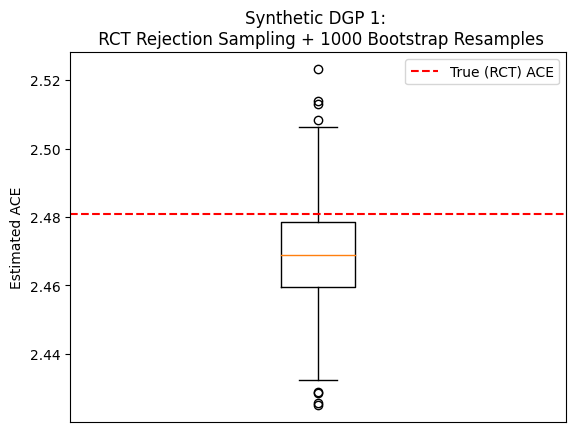

In [43]:
plt.boxplot(all_sample_ace)
plt.title('Synthetic DGP 1: \n RCT Rejection Sampling + 1000 Bootstrap Resamples')
plt.ylabel('Estimated ACE')
plt.xticks([])
plt.axhline(y=rct_ace, color='r', linestyle='--', label="True (RCT) ACE")
plt.legend()
plt.show()

### Synthetic DGP Setting #2 
`|C| = 1, P (T = 1) = 0.5 `

In [6]:
#######################
# DGP for RCT T->Y<-C
######################
num_samples = 100000

#keep the random seed for the DGP distinct from the sampling seed 
rng_dgp = np.random.default_rng(0)

C = rng_dgp.binomial(1, 0.5, num_samples)
T = rng_dgp.binomial(1, 0.5, num_samples) #Set P(T=1)=0.5
Y = 0.5*C + 1.5*T + 2*T*C + rng_dgp.normal(0, 1, num_samples)
data = pd.DataFrame({"C": C, "T": T, "Y": Y})

# perform some sanity checks
# in the RCT data we should see unadjusted == adjusted 
rct_ace =  parametric_backdoor(data, "Y", "T", [])
print("RCT ACE unadjusted", rct_ace)
print("RCT ACE adjusting for C", parametric_backdoor(data, "Y", "T", ["C", "T*C"]))

RCT ACE unadjusted 2.4880390135966186
RCT ACE adjusting for C 2.4855817263396593


The cell below gives the results for the two different sampling algorithms for the synthetic DGP setting in the cell above across 1000 random seeds. 

In [7]:
confound_func_params={"para_form": "linear"} 
_ = many_seeds(data, rct_ace, confound_func_params, is_linear=True, num_seeds=1000)

Invalid sample, T*C==T for all units
OBRCT num invalid samples= 1
Rejection num invalid samples= 1

OBSRCT: MAE (over1000 random seeds)=  0.00851488463523465
	OBSRCT: std AE (over1000 random seeds)=  0.0064717555624195676
OBSRCT: Relative MAE (over1000 random seeds)=  0.0034223276197449344
	OBSRCT: Relative AE std (over1000 random seeds)=  0.002601147139193864

Rejection: MAE (over 1000 random seeds)=  0.006830749100601587
	Rejection: std AE (over 1000 random seeds)=  0.005199595314186686
Rejection: Relative MAE (over1000 random seeds)=  0.0027454348839680387
	Rejection: Relative AE std (over1000 random seeds)=  0.002089836729155762


### Synthetic DGP Setting #3 
`|C| = 5, Nonlinear`

In [8]:
# DGP
num_samples = 100000
rng_dgp = np.random.default_rng(0)

#keep the random seed for the DGP distinct from the sampling seed 
rng_dgp = np.random.default_rng(0)

C1 = rng_dgp.binomial(1, 0.5, num_samples)
C2 = C1 + rng_dgp.uniform(-0.5, 1, num_samples)
C3 = rng_dgp.normal(0, 1, num_samples)
C4 = rng_dgp.normal(0, 1, num_samples)
C5 = C3 + C4 + rng_dgp.normal(0, 1, num_samples)
T = rng_dgp.binomial(1, 0.3, num_samples)
Y = 0.5*C4 + 2*T*C1*C2 - 1.5*T + C2*C3 + C5 + rng_dgp.normal(0, 1, num_samples)
data = pd.DataFrame({"C1": C1, "C2": C2, "C3": C3, "C4": C4, "C5": C5, "T": T, "Y": Y})
print("RCT ACE", np.mean(data[data['T'] == 1]["Y"]) - np.mean(data[data['T'] == 0]["Y"]))

RCT ACE -0.2574222302855121


In [9]:
rct_ace =  parametric_backdoor(data, "Y", "T", [])
print("RCT ACE unadjusted", rct_ace)
print("RCT ACE adjusting for C ", parametric_backdoor(data, "Y", "T", []))

RCT ACE unadjusted -0.2574222302855136
RCT ACE adjusting for C  -0.2574222302855136


The cell below gives the results for the two different sampling algorithms for the synthetic DGP setting in the cell above across 1000 random seeds. 

In [10]:
confound_func_params = {"para_form": "nonlinear", "C1": 1.5, "C2": -0.7, "C3": 1.2, "C4": 1.5, "C5": -1.2}
_ = many_seeds(data, rct_ace, confound_func_params, is_linear=False, num_seeds=1000)

OBRCT num invalid samples= 0
Rejection num invalid samples= 0

OBSRCT: MAE (over1000 random seeds)=  0.2519952295473326
	OBSRCT: std AE (over1000 random seeds)=  0.009636055470132234
OBSRCT: Relative MAE (over1000 random seeds)=  0.9789179017982955
	OBSRCT: Relative AE std (over1000 random seeds)=  0.03743288005641408

Rejection: MAE (over 1000 random seeds)=  0.01184686280238446
	Rejection: std AE (over 1000 random seeds)=  0.008859601949149221
Rejection: Relative MAE (over1000 random seeds)=  0.04602113340889325
	Rejection: Relative AE std (over1000 random seeds)=  0.03441661560978168
